I made this textbook just to make everything a bit more streamlined. I want to keep everything that's important for the proof of concept here so I don't have to run again/ scroll a lot

In [1]:
import matplotlib.pyplot as plt

import jax 
import jax.numpy as jnp
import numpy as np
from jax import value_and_grad, jit, random, vmap

import optax
from functools import partial

import tqdm

In [2]:
def runge_kutta_step_with_params(X, params, t, rhs, dt):
    """
    Single step definition of the 4th order Runge-Kutta method
    X : State vector
    params : Parameter list
    t : Time
    rhs : Function defining right hand side of ODE
    dt: Timestep

    Important item of note, there are a couple conventions with regards to RK solvers
    You can either return the next step (i.e. X + RK_step)
    or you can return the increment (i.e. RK_step)
    This function definition returns the increment
    """

    k1 = rhs(X, t, params)
    k2 = rhs(X + dt/2 * k1, t + dt/2, params)
    k3 = rhs(X + dt/2 * k2, t + dt/2, params)
    k4 = rhs(X + dt * k3, t + dt, params)
    inc = dt/6 * (k1 + 2*k2+ 2*k3 + k4)
    return inc


@partial(jax.jit, static_argnames=['rhs'])
def runge_kutta_solve(X0, rhs, ts, params):
    """
    Loop definition of the 4th order Runge-Kutta method using the single step definition
    X0 : Initial condition vector
    rhs : Function defining right hand side of ODE
    ts : Time vector
    params : Parameter list

    """
    dt=ts[1]-ts[0]

    def loop_body(x,t):
        dx = runge_kutta_step_with_params(x,params,t,rhs,dt)
        x = x + dx
        return x,x
    
    _,Xs=jax.lax.scan(loop_body,X0,ts[:-1])
    return Xs,ts[1:]

# Batch the above function
batched_param_runge_kutta_solve = jax.vmap(runge_kutta_solve, in_axes=[None, None, None, 0], out_axes=0)

batched_runge_kutta_solve = jax.vmap(runge_kutta_solve, in_axes=[0, None, None, None], out_axes=0)

def lorenz_rhs(X, t, params):
    """
    Right hand side of the Lorenz system
    X : State vector
    t : Time
    params : Parameter list

    """
    x, y, z = X
    sigma, rho, beta = params
    x_dot = sigma * (y - x)
    y_dot = x*(rho - z) - y
    z_dot = x*y - beta*z
    return jnp.array([x_dot, y_dot, z_dot])

def solve_lorenz(X0, params, t_end, n_steps):
    """
    Solve the Lorenz system using the Runge-Kutta method
    X0 : Initial condition vector
    params : Parameter list (has form [sigma, rho, beta])
    t_end : End time
    n_steps : Number of time steps

    """
    ts = jnp.linspace(0, t_end, n_steps)
    Xs, ts_out = runge_kutta_solve(X0, lorenz_rhs, ts, params)

    return Xs, ts_out

solve_lorenz_batch_params = jax.vmap(solve_lorenz, in_axes=(None, 0, None, None), out_axes=(0,None))
solve_lorenz_batch_X0 = jax.vmap(solve_lorenz, in_axes=(0, None, None, None), out_axes=(0, None))

def random_parameter_vector(key, batchsize, ranges):
    """
    Generate a batch of random parameters of size batchsize 
    within a given range for each parameter.
    key : JAX random key
    batchsize : Number of parameters to generate
    ranges : List of tuples defining (mix, max) for each parameter

    """
    params = []
    subkeys = jax.random.split( key, len(ranges) )
    for subkey, value_range in zip(subkeys, ranges):
        params.append(jax.random.uniform(subkey, [batchsize], minval = value_range[0], maxval = value_range[1]))
    return params

def lorenz_produce_training_batch(key, batchsize, ranges, t_end, n_steps, X0):
    """
    Produce a batch of training data with random parameters
    key : Random Jax key
    batchsize : Number of training examples to produce
    ranges : List of tuples defining (min, max) for each parameter
    t_end : End time for simulation
    n_steps : Number of time steps for simulation

    """
    sigmas, rhos, betas = random_parameter_vector(key, batchsize, ranges)
    params = jnp.stack([sigmas, rhos, betas], axis=1)
    Xs, ts = solve_lorenz_batch_params(X0, params, t_end, n_steps)
    return Xs, ts, params

dim_obs_bool = np.array([True, False, False])
keep_idx = tuple(np.nonzero(dim_obs_bool)[0].tolist())

def chen_rhs(X, t, params):
    """
    Right hand side of the Chen system
    X : State vector
    t : Time
    params : Parameter list
    """
    x, y, z = X
    alpha, gamma, epsilon = params
    x_dot = alpha * (y - x)
    y_dot = (gamma - alpha) * x - x*z + gamma * y
    z_dot = x*y - epsilon * z
    return jnp.array([x_dot, y_dot, z_dot])

def rossler_rhs(X, t, params):
    """
    Right hand side of the Rossler system
    X : State vector
    t : Time
    params : Parameter List
    """
    x, y, z = X
    phi, theta, xi = params
    x_dot = -y - z
    y_dot = x + phi * y
    z_dot = theta + z * (x - xi)
    return jnp.array([x_dot, y_dot, z_dot])

def solve_chen(X0, params, tend, nsteps):
    """
    Solve the Chen system using the Runge-Kutta method
    X0 : Initial state vector
    params : Parameter list
    tend : End time
    nsteps : Number of time steps 
    """
    ts = jnp.linspace(0, tend, nsteps)
    Xs, ts_out = runge_kutta_solve(X0, chen_rhs, ts, params)
    return Xs, ts_out

def solve_rossler(X0, params, tend, nsteps):
    """
    Solve the Rossler system using the Runge-Kutta method
    X0 : Initial state vector
    params : Parameter list
    tend : End time
    nsteps : Number of time steps 
    """
    ts = jnp.linspace(0, tend, nsteps)
    Xs, ts_out = runge_kutta_solve(X0, rossler_rhs, ts, params)
    return Xs, ts_out

solve_chen_batch_params = jax.vmap(solve_chen, in_axes=(None, 0, None, None), out_axes=(0,None))
solve_chen_batch_X0 = jax.vmap(solve_chen, in_axes=(0, None, None, None), out_axes=(0, None))
solve_rossler_batch_params = jax.vmap(solve_rossler, in_axes=(None, 0, None, None), out_axes=(0,None))
solve_rossler_batch_X0 = jax.vmap(solve_rossler, in_axes=(0, None, None, None), out_axes=(0, None))

def chen_produce_training_batch(key, batchsize, ranges, t_end, n_steps, X0):
    """
    Produce a batch of training data with random parameters
    key : Random Jax key
    batchsize : Number of training examples to produce
    ranges : List of tuples defining (min, max) for each parameter
    t_end : End time for simulation
    n_steps : Number of time steps for simulation

    """
    alphas, gammas, epsilons = random_parameter_vector(key, batchsize, ranges)
    params = jnp.stack([alphas, gammas, epsilons], axis=1)
    Xs, ts = solve_chen_batch_params(X0, params, t_end, n_steps)
    return Xs, ts, params

def rossler_produce_training_batch(key, batchsize, ranges, t_end, n_steps, X0):
    """
    Produce a batch of training data with random parameters
    key : Random Jax key
    batchsize : Number of training examples to produce
    ranges : List of tuples defining (min, max) for each parameter
    t_end : End time for simulation
    n_steps : Number of time steps for simulation

    """
    phis, thetas, xis = random_parameter_vector(key, batchsize, ranges)
    params = jnp.stack([phis, thetas, xis], axis=1)
    Xs, ts = solve_rossler_batch_params(X0, params, t_end, n_steps)
    return Xs, ts, params

ranges = {
    0 : [(6.0, 12.0), (20.,30.), (0.5,2.5)],  # Lorenz: sigma, rho, beta
    1 : [(30.0, 40.0), (20.0, 30.0), (1.0, 5.0)], #Chen: alpha, gamma, epsilon
    2 : [(0.1, 0.3), (0.1, 0.3), (5.2, 6.2) ] #Rössler: phi, theta, xi
}

reg_dims = {0:3, 1:3, 2:3}
S  = 3
Pmax = max(reg_dims.values())

sys_fun = {0: lorenz_rhs, 1: chen_rhs, 2: rossler_rhs}

def draw_params_for_system(key, sys_id, ranges):
    """"
    Draw a random parameter vector for a given system id
    key : Random Jax key
    sys_id : System ID (0 = Lorenz, 1 = Chen, 2 = Rössler)
    ranges : Dictionary of parameter ranges for each system"""
    ks = jax.random.split(key, len(ranges[sys_id]))
    vals = [jax.random.uniform(k, (), minval=lo, maxval=hi)
            for k, (lo,hi) in zip(ks, ranges[sys_id])]
    return jnp.stack(vals)  # (P_s,)

def simulate_one(key, sys_id, X0, t_end, n_steps, ranges):
    """
    Simulate one trajectory for a given system ID
    key : Random Jax key
    sys_id : System ID (0 = Lorenz, 1 = Chen, 2 = Rössler)
    X0 : Initial state vector
    t_end : End time
    n_steps : Number of time steps
    ranges : Dictionary of parameter ranges for each system
    """
    ts = jnp.linspace(0., t_end, n_steps)
    params = draw_params_for_system(key, sys_id, ranges)
    Xs, _  = runge_kutta_solve(X0, sys_fun[sys_id], ts, params)  # (T,3) with T=n_steps-1
    return Xs, ts[1:], params


def normalize_keep_idx(keep_idx, C_max: int = 3):
    """Return keep_idx as a tuple of ints; accept int/list/tuple/np/jnp."""
    if isinstance(keep_idx, (int, np.integer)):
        keep_idx = (int(keep_idx),)
    else:
        keep_idx = tuple(int(i) for i in np.array(keep_idx).reshape(-1).tolist())
    assert len(keep_idx) > 0, "keep_idx must contain at least one channel index"
    assert all(0 <= i < C_max for i in keep_idx), f"keep_idx must be in [0,{C_max-1}]"
    return keep_idx

def featurize_compact(X_sel):
    """
    X_sel: (B, T, C_sel) → z-score over time, then flatten → (B, T*C_sel)
    """
    mean = jnp.mean(X_sel, axis=1, keepdims=True)
    std  = jnp.std(X_sel,  axis=1, keepdims=True) + 1e-6
    Xn   = (X_sel - mean) / std
    return Xn.reshape(Xn.shape[0], -1)


def featurize_padded(Xs_pad):
    # per-sample, per-channel z-score over time, then flatten
    mean = jnp.mean(Xs_pad, axis=1, keepdims=True)
    std  = jnp.std(Xs_pad,  axis=1, keepdims=True) + 1e-6
    Xn   = (Xs_pad - mean) / std
    return Xn.reshape(Xn.shape[0], -1)  # (B, T*C_max)

def to_padded_params(params_vec, reg_dim, Pmax):
    """
    """
    pad = Pmax - reg_dim
    y   = jnp.pad(params_vec, (0, pad))
    m   = jnp.concatenate([jnp.ones((reg_dim,)), jnp.zeros((pad,))])
    return y, m

def produce_system_batch(key, B_batch, keep_idx, X0, t_end, n_steps, ranges):
    """
    key : Random Jax key
    B_batch : Batchsize 
    keep_idx : Tuple of positions inditcating with channels are present (e.g., (0,) for x; (0,2) for x,z; (0,1,2) for x,y,z)
    X0 : Initial state vector 
    t_end : Time for simulation
    n_steps : Number of time steps of simulation
    ranges : Dictionary containing the ranges for each system

    Returns:
      feats: (batchsize, input dimention),  sys_ids: (batchsize,)
      y_params_padded: (batchsize, max parameter amount),
      y_mask: (batchsize, max parameter amount)
    """
    keep_idx = normalize_keep_idx(keep_idx, C_max=3)
    T = n_steps - 1
    keys = jax.random.split(key, B_batch + 1)
    key_sys, keys_draw = keys[0], keys[1:]

    # sample system ids uniformly
    sys_ids = jax.random.randint(key_sys, (B_batch,), 0, S)

    X_list, y_list, m_list = [], [], []
    for i in range(B_batch):
        k1 = keys_draw[i]
        sid = int(sys_ids[i])
        Xs, ts, p = simulate_one(k1, sid, X0, t_end, n_steps, ranges)  # (T,3)

        # --- slice observed channels only (no padding) ---
        Xs_sel = Xs[:, list(keep_idx)][None, ...]         # (1, T, C_sel)
        feats  = featurize_compact(Xs_sel)                # (1, T*C_sel)

        y_pad, m = to_padded_params(p, reg_dims[sid], Pmax)
        X_list.append(feats[0]); y_list.append(y_pad); m_list.append(m)

    feats = jnp.stack(X_list, axis=0)                    # (B, T*C_sel)
    y_params_padded = jnp.stack(y_list, axis=0)          # (B, Pmax)
    y_mask = jnp.stack(m_list, axis=0)                   # (B, Pmax)

    # Safety: all leading dims equal
    assert feats.shape[0] == sys_ids.shape[0] == y_params_padded.shape[0] == y_mask.shape[0], \
        f"Batch mismatch: feats {feats.shape}, sys {sys_ids.shape}, y {y_params_padded.shape}, mask {y_mask.shape}"
    return feats, sys_ids, y_params_padded, y_mask


In [3]:
def init_linear(key, din, dout):
    """
    key : Random Jax key
    din : Input dimention
    dout : Output dimention

    Returns : Dictionaries of 'W' (weights) and 'B' (baises)
    """
    W = jax.random.normal(key, (din, dout)) / jnp.sqrt(din)
    b = jnp.zeros((dout,))
    return {'W': W, 'b': b}

def apply_linear(params, x):  # x: (B,din)
    """
    params : Parameter list
    x : Input state
    
    Returns : The (wx+b) layer of the neural net
    """
    return x @ params['W'] + params['b']

def init_mlp(key, sizes):
    """
    key : Random Jax key
    sizes : Number of layers
    
    Return : Construct the initial weights and baises of the neural net 
            using the init_layer function
    """
    params = []
    ks = jax.random.split(key, len(sizes)-1)
    for (din, dout), k in zip(zip(sizes[:-1], sizes[1:]), ks):
        params.append(init_linear(k, din, dout))
    return params

def apply_mlp(params, x):
    """
    params : Parameter list
    x : State vector
    
    Returns : The full output of a single neural net pass, from the matmul to the 
            activation function
    """
    for i, lyr in enumerate(params):
        x = apply_linear(lyr, x)
        if i < len(params)-1:
            x = jnp.tanh(x)
    return x

def init_moe(key, D_in, enc_sizes, reg_dims, n_systems=S):
    """
    key: Random Jax key
    D_in : Input dimention
    enc_sizes : List of encoder sizes (except for the input dimetion)
    reg_dims : Dictionaory of number of parameters of different systems
    n_systems : Number of system
    
    Returns : A dictionary of enc: parameters of the encoded MLP, gate: linear head for the router logistics,
        experts: MLPs (or linear layers) that do the parameter estimation
    """
    k_enc, k_gate, *k_exps = jax.random.split(key, 2 + n_systems)
    enc = init_mlp(k_enc, [D_in, *enc_sizes])             # encoder -> H
    H   = enc_sizes[-1]
    gate = init_linear(k_gate, H, n_systems)              # router head
    experts = {s: init_linear(k_exps[s], H, reg_dims[s]) for s in range(n_systems)}
    return {'enc': enc, 'gate': gate, 'experts': experts}

def forward_moe(params, feats):
    """
    params : Parameter list
    feats : Time series data 
    reg_dims : Dictionaory of number of parameters of different systems
    Pmax : Max number of parameters in reg_dims

    Returns : Forwards pass of one MoE layer in logits: router scores (i.e. probabilites associated with each system),
        and preds: per system parameter predictions
    """

    h      = apply_mlp(params['enc'], feats)   # (B,H)
    logits = apply_linear(params['gate'], h)   # (B,S)

    # Compute Pmax from static shapes of expert heads (no runtime args)
    S = len(params['experts'])
    Pmax = max(params['experts'][s]['b'].shape[0] for s in range(S))  # Python int

    preds = []
    for s in range(S):
        head = params['experts'][s]
        p    = apply_linear(head, h)                       # (B, P_s)
        Ps   = head['b'].shape[0]                          # Python int (static)
        pad  = jnp.zeros((p.shape[0], Pmax - Ps), dtype=p.dtype)  # (B, Pmax-Ps)
        p_pad = jnp.concatenate([p, pad], axis=1)          # (B, Pmax) (works even if Pmax-Ps == 0)
        preds.append(p_pad)

    preds = jnp.stack(preds, axis=1)                       # (B,S,Pmax)
    return logits, preds

def moe_loss(params, feats, sys_ids, y_params_padded, y_mask, lam_reg=0.5):
    """
    params : Parameter list
    feats : Time series data
    sys_ids : Numerical identifier of system
    y_params_padded : True parameter vectors extended to Pmax
    y_mask : Mask that only retains wanted dimentions
    reg_dims : Dimtionary of number of parameters of different systems
    Pmax : Max number of parameters in reg_dims
    lam_reg : Weight balancing classification and regression
    
    Returns : The full calculated loss of the function
    """
    logits, preds = forward_moe(params, feats)
    ce = optax.softmax_cross_entropy_with_integer_labels(logits, sys_ids).mean()

    onehot = jax.nn.one_hot(sys_ids, logits.shape[-1])[:, :, None]  # (B,S,1)
    pred_true = jnp.sum(preds * onehot, axis=1)                     # (B,Pmax)

    num = jnp.sum(((pred_true - y_params_padded)**2) * y_mask)
    den = jnp.sum(y_mask) + 1e-8
    mse = num / den
    return ce + lam_reg * mse

moe_valgrad = jax.jit(jax.value_and_grad(moe_loss, argnums=0))

optimizer = optax.adam(1e-3)

@jax.jit
def train_step(params, opt_state, feats, sys_ids, y_params_padded, y_mask):
    loss, grads = moe_valgrad(params, feats, sys_ids, y_params_padded, y_mask)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [4]:
# Config
X0 = jnp.array([1.,1.,1.])
t_end, n_steps = 40.0, 4000
T = n_steps - 1
keep_idx = normalize_keep_idx(keep_idx)
D_in = T * len(keep_idx)       
enc_sizes = [256, 128]           # encoder widths
optimizer = optax.adam(1e-3)
num_steps = 25000

# Init
key = jax.random.key(0)
key, kinit = jax.random.split(key)
moe_params = init_moe(kinit, D_in, enc_sizes, reg_dims, n_systems=S)
opt_state  = optimizer.init(moe_params)
B_train = 128
B_val = 400

losses = []


In [ ]:
#Training Loop
for step in range(num_steps):
    key, kb = jax.random.split(key)
    feats, sys_ids, y_pad, y_mask = produce_system_batch(
        kb, B_batch=B_train, keep_idx=keep_idx, X0=X0, t_end=t_end, n_steps=n_steps, ranges=ranges
    )
    moe_params, opt_state, loss = train_step(moe_params, opt_state, feats, sys_ids, y_pad, y_mask)
    losses.append(float(loss))
    if num_steps // 100 == 0:   
        print("Currently on num_steps:", num_steps)



val sys_id counts: {0: 138, 1: 125, 2: 137}


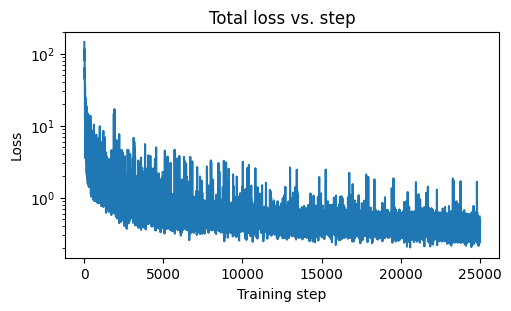

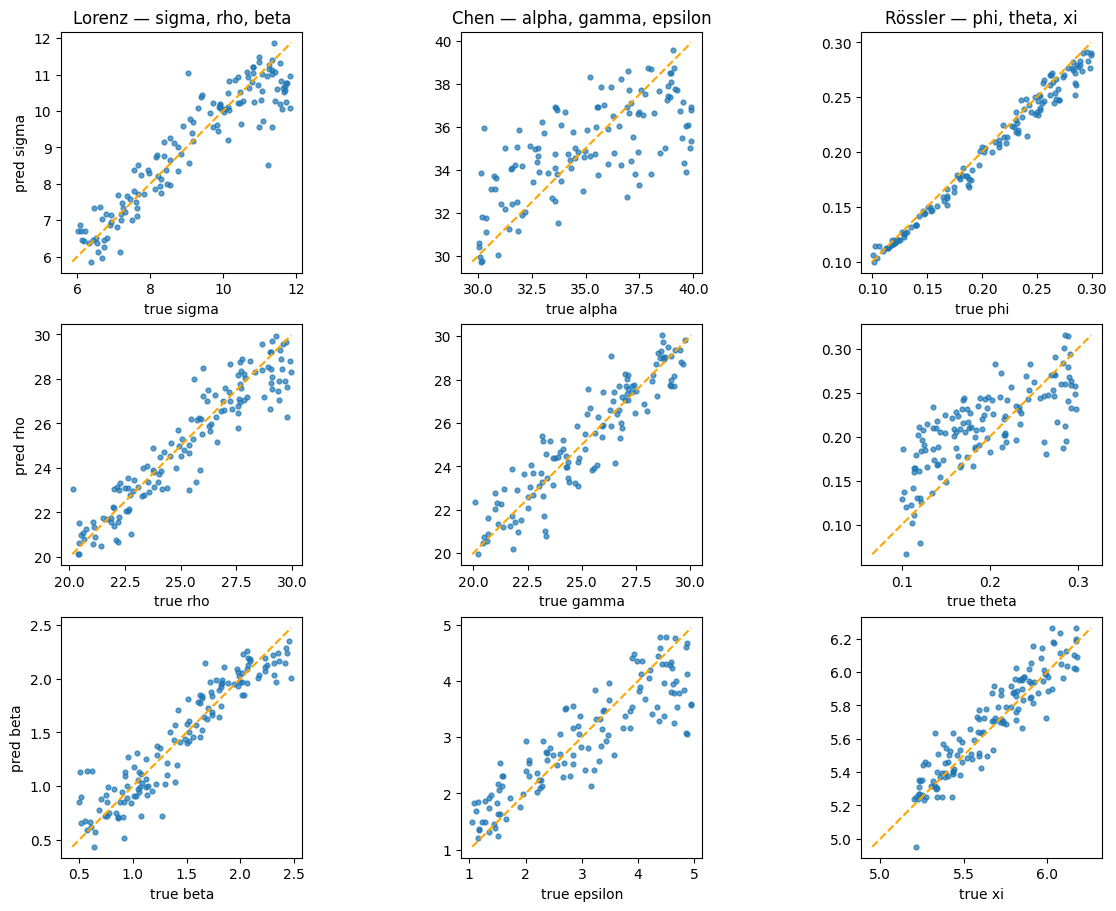

router probs: [1.7436710e-13 4.3534058e-07 9.9999952e-01]
pred system id (0=Lorenz,1=Chen,2=Rössler): 2
true params: [0.28680703 0.2650341  5.350169  ]
pred params: [0.28055707 0.225269   5.4880347 ]
percent error: [ 2.179153  15.003769   2.5768447]


In [ ]:
# ---- Validation batch (distinct names)
key, kb = jax.random.split(key)
feats_val, sys_val, y_val, mask_val = produce_system_batch(
    kb, B_batch=B_val, keep_idx=keep_idx, X0=X0, t_end=t_end, n_steps=n_steps, ranges=ranges
)
counts = np.bincount(np.asarray(sys_val), minlength=S)
print("val sys_id counts:", {i:int(c) for i,c in enumerate(counts)})

# ---- Forward pass (validation)
logits, preds = forward_moe(moe_params, feats_val)

# To NumPy + shapes
preds_np  = np.asarray(preds)                               # (Bp,S,Pmax)
sys_np    = np.asarray(sys_val, dtype=np.int32).reshape(-1) # (Bi,)
y_pad_np  = np.asarray(y_val)                               # (By,Pmax)
y_mask_np = np.asarray(mask_val)                            # (Bm,Pmax)

Bp, S, Pmax = preds_np.shape
Bi, By, Bm  = sys_np.shape[0], y_pad_np.shape[0], y_mask_np.shape[0]
if len({Bp, Bi, By, Bm}) != 1:
    minB = min(Bp, Bi, By, Bm)
    print(f"[plot] Mismatched batch sizes (preds={Bp}, sys={Bi}, y={By}, mask={Bm}); truncating to {minB}.")
    preds_np, sys_np, y_pad_np, y_mask_np = preds_np[:minB], sys_np[:minB], y_pad_np[:minB], y_mask_np[:minB]
else:
    minB = Bp

# Pick the true-system predictions
pred_np = np.take_along_axis(preds_np, sys_np[:, None, None], axis=1)[:, 0, :]

# ---- Names (only change!)
SYSTEM_NAMES = {
    0: "Lorenz",
    1: "Chen",
    2: "Rössler",
}

PARAM_NAMES = {
    0: ["sigma", "rho", "beta"],     # Lorenz
    1: ["alpha", "gamma", "epsilon"], # Chen
    2: ["phi", "theta", "xi"],       # Rössler 

}

# ---- Figure 0: loss curve (unchanged)
fig0, ax0 = plt.subplots(ncols=1, figsize=(5, 3), constrained_layout=True)
ax0.plot(np.asarray(losses))
ax0.set_yscale("log")
ax0.set_title("Total loss vs. step")
ax0.set_xlabel("Training step"); ax0.set_ylabel("Loss")
plt.show()

# ---- Figure 1: grid of scatters (rows=Pmax, cols=S)  <-- back to your original layout
fig, ax = plt.subplots(nrows=Pmax, ncols=S, figsize=(4*S, 3*Pmax),
                       constrained_layout=True, squeeze=False)

for s in range(S):
    sel = (sys_np == s)
    if not np.any(sel):
        for r in range(Pmax):
            ax[r, s].axis('off')
        ax[0, s].set_title(f"{SYSTEM_NAMES.get(s, f'System {s}')} (no samples)")
        continue

    # Same assumption as before: first sample of this system defines valid columns
    cols = np.where(y_mask_np[sel][0] == 1)[0]
    names = PARAM_NAMES.get(s, [f"p{j}" for j in range(len(cols))])

    for j, c in enumerate(cols):
        a = ax[j, s]
        t = y_pad_np[sel, c]
        p = pred_np[sel, c]
        m = np.isfinite(t) & np.isfinite(p)
        t, p = t[m], p[m]
        if t.size == 0:
            a.axis('off'); continue

        a.scatter(t, p, s=12, alpha=0.7)
        lo = np.min(np.concatenate([t, p])); hi = np.max(np.concatenate([t, p]))
        pad = 0.05 * (hi - lo) if hi > lo else 1.0
        a.plot([lo, hi], [lo, hi], "--", color="orange")
        a.set_xlim(lo - pad, hi + pad); a.set_ylim(lo - pad, hi + pad)
        a.set_aspect("equal", adjustable="box")

        pname = names[j] if j < len(names) else f"p{j}"
        a.set_xlabel(f"true {pname}")
        if s == 0:
            a.set_ylabel(f"pred {pname}")

    # turn off unused rows
    for r in range(len(cols), Pmax):
        ax[r, s].axis('off')

    # Title uses system display name + parameter names
    ax[0, s].set_title(f"{SYSTEM_NAMES.get(s, f'System {s}')} — {', '.join(names)}")

plt.show()


In [17]:
# Simulate one example, sys_id: 0 = Lorenz, 1 = Chen, 2 = Rössler
key, kx = jax.random.split(key)
Xs, ts, params_true = simulate_one(kx, sys_id=2, X0=X0, t_end=t_end, n_steps=n_steps, ranges=ranges)

# Use the SAME keep_idx as train/val
X_sel  = Xs[:, list(keep_idx)][None, ...]   # (1, T, C_sel)
feats_one = featurize_compact(X_sel)        # (1, T*C_sel)

logits1, preds1 = forward_moe(moe_params, feats_one)
p = jax.nn.softmax(logits1, axis=-1)[0]
s_hat = int(jnp.argmax(p))
pred_padded = preds1[0, s_hat]              # (Pmax,)
pred_params = pred_padded[:reg_dims[s_hat]]

print("router probs:", np.asarray(p))
print("pred system id (0=Lorenz,1=Chen,2=Rössler):", s_hat)
print("true params:",  np.asarray(params_true))
print("pred params:",  np.asarray(pred_params))
per_err = 100.0 * np.abs((np.asarray(pred_params) - np.asarray(params_true)) / np.asarray(params_true))
print("percent error:", per_err)

router probs: [7.6111189e-14 2.6788499e-08 1.0000000e+00]
pred system id (0=Lorenz,1=Chen,2=Rössler): 2
true params: [0.16046686 0.2704477  6.063859  ]
pred params: [0.15563907 0.29025662 6.008037  ]
percent error: [3.0085945 7.3244915 0.9205672]
